#### MOUNT DRIVE

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### INSTALL DEPENDENCIES AND IMPORT LIBRARIES

In [1]:
!pip install transformers
!pip install datasets
!pip install sacrebleu
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 6.5 MB/s eta 0:00:0

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPT2LMHeadModel
from datasets import Metric, load_metric

torch.cuda.empty_cache()

In [3]:
!git clone https://github.com/nelson-nsc/ucl-nlp.git

Cloning into 'ucl-nlp'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 186 (delta 26), reused 33 (delta 19), pack-reused 137
Receiving objects: 100% (186/186), 7.98 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [4]:
%cd /content/ucl-nlp
import evaluation
%cd ..

/content/ucl-nlp
/content


#### LOAD THE TEST AND VAL DATA
val data is to select tempurature parameter

In [5]:
test_df = pd.read_csv('/content/ucl-nlp/data/conala-hq-marian/hq_test.csv')
val_df = pd.read_csv('/content/ucl-nlp/data/conala-hq-marian/hq_val.csv')

#### TOKENIZER

In [6]:
# define the tokenizer 
tokenizer = GPT2Tokenizer.from_pretrained('gpt2',  bos_token='<|startoftext|>',  eos_token='<|endoftext|>', pad_token='<|pad|>', padding_side='left')
tokenizer.add_tokens([['<ZZZ>']])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

### LOAD IN FINE-TUNED MODELS

#### HQ DATA TRAINED MODEL

In [9]:
hq_model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/trained_models/fineTunedGPT2_hq_Z').cuda()
hq_model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

#### MIXED DATA TRAINED MODEL

In [10]:
mixed_model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/trained_models/fineTunedGPT2_hq_Z_mix_3').cuda()
mixed_model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

#### AUGMENTED DATA TRAINED MODEL

In [11]:
aug_model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/trained_models/fineTunedGPT2_hq_Z_aug_3').cuda()
aug_model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

#### CODE GENERATION

In [12]:
## define a method to generate code from NL
def generate_response(NL, model, tokenizer, temp, n_out):

  inputs = tokenizer('<|startoftext|> ' + NL + ' <ZZZ> ', return_tensors='pt')

  input_ids = inputs.input_ids.to("cuda")
  attention_mask = inputs.attention_mask.to("cuda")

  outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, do_sample=True, top_k=50, max_length=75, top_p=0.99,
                                 temperature=temp, num_return_sequences=n_out, pad_token_id=tokenizer.encode('<|pad|>')[0])
  
  return [[tokenizer.decode(out, skip_special_tokens=True)] for out in outputs]

#### GET TEMPURATURE USING VALIDATION

In [ ]:
temps = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

temp_results = [get_bleu_score(val_df, tokenizer, hq_model, t) for t in temps]

temp_results

#### EVALUATION

In [13]:
evaluator = evaluation.CodeGenerationEvaluator(tokenizer, 'cuda', smooth_bleu=True)

/content/ucl-nlp/evaluation.py:32: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.sacre_bleu: Metric = load_metric('sacrebleu')


In [ ]:
def get_preds(test_df, model, tokenizer, temp):
  results = []
  for i in range(len(test_df)):
    row = test_df.iloc[i]

    output_str = generate_response(row['intent'], model, tokenizer, temp, 1)[0][0]
    output_str = output_str.split('<ZZZ>')[1].lstrip(' ')

    results.append(output_str)

  return results

In [ ]:
def get_bleu_score(test_df, tokenizer, model, temp):
  bleu = 0

  preds = get_preds(test_df, model, tokenizer, temp)  # get predicted responses

  for i in range(len(preds)):

    ref = test_df['snippet'][i]                       # actual snippet
    pred = preds[i]                                   # predicted snippet

    if pred is not None and pred != "":

      if ref is not None and ref != "":
       
        metrics = evaluator.evaluate([pred], [ref])

        bleu += metrics['BLEU']
  
  return bleu/len(preds)



#### EVALUATE THE MODELS

In [ ]:
# get 10 instances since gpt-2 is generative and thus results will slighlty vary from
models = [hq_model, mixed_model, aug_model]
temp = 0.1

all_bleus = np.zeros((10,3))
for i in range(10):
  bleu_scores = [get_bleu_score(test_df, tokenizer, model, temp) for model in models]
  all_bleus[i] = bleu_scores

#bleu_scores = [get_bleu_score(test_df, tokenizer, model, temp) for model in models]


In [ ]:
print(all_bleus.mean(0))
print(all_bleus.std(0))

[25.35302198 25.09977374 25.21758252]
[0.21803458 0.31369717 0.3515836 ]


In [ ]:
bleu_scores

[26.05937314403518, 25.19779852064279, 25.379249465803618]

#### CHECK PERFORMANCE ON DIFFERENT LENGTHS OF SNIPPETS

In [ ]:
# check performance on differnet lengths of snippets
lengths = [0, 10, 20, 30, 40, 50, 60, 70]
results = []
yes = lambda x, l: len(x) > l

for l in lengths:
  idx = []

  for i in range(len(test_df)):
    if yes(test_df.iloc[i]['snippet'], l):
      idx.append(i)

  df = test_df.iloc[idx]
  df.reset_index(drop=True, inplace=True)
  
  results.append(get_bleu_score(df, tokenizer, aug_model, 0.1))
  

In [ ]:
results

[26.186927064720408,
 24.612248807707598,
 23.003873108134243,
 22.42810483157713,
 19.634138815098698,
 18.773096348891922,
 18.562921873848442,
 23.19419074727803]

In [ ]:
import matplotlib.pyplot as plt


Text(0.5, 0, 'number of characters in snippet')

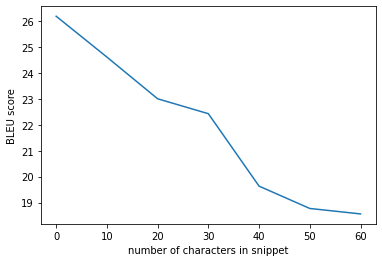

In [ ]:
plt.plot(lengths[0:-1], results[0:-1])
plt.ylabel('BLEU score')
plt.xlabel('number of characters in snippet')

####PLAY AROUND

In [15]:
model = hq_model
temp = 0.1
n_out = 5

generate_response('how variable type python?', model, tokenizer, temp, n_out)

[[' how variable type python? <ZZZ>  type(int)'],
 [' how variable type python? <ZZZ>  type(a)'],
 [' how variable type python? <ZZZ>  type(a)'],
 [' how variable type python? <ZZZ>  type(a)'],
 [' how variable type python? <ZZZ>  type(a)']]